In [41]:
import tweepy as tw
import pandas as pd
import numpy as np
import nltk
import re
import os
import pandas as pd
import numpy as np
import tweepy as tw
import nltk
import re
import networkx
import matplotlib.pyplot as plt
import seaborn as sns
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim()
import googletrans
import json
from wordcloud import WordCloud

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from  bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
token = WordPunctTokenizer()

C:\Users\sidha\Anaconda3\New folder\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


In [2]:
consumer_key = 'w3as5bWjsiL7lE5Zp5iDGlvyk'
consumer_secret = 'reH3HcOheQ2XO9G2r4LTgvL8z3wjZU5o7J4VGNWq4ExVHGpygd'
access_token = '937619443525369856-riXDgWRmf7k95BmUCsXBIrfSZky8lt0'
access_token_secret = '3Mk9fSR0Suk9fmMGJmJURjw4QGGxw3J9pj8rjChTtn6vp'

In [3]:
auth = tw.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tw.API(auth,wait_on_rate_limit = True)



In [4]:
import pandas as pd
df = pd.read_csv("hello.csv")

In [5]:
import demoji
demoji.download_codes()

... OK (Got response in 3.74 seconds)
Writing emoji data to C:\Users\sidha\.demoji/codes.json ...
... OK


In [6]:
df['tweet'] = df['tweet'].apply(lambda x : demoji.replace(x,repl = ""))

In [7]:
# r'@[A-Za-z0-9_]+|https?:\/\/[^ ]+'
username_hyper_link = r'https?:\/\/[^ ]+'
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not",
                 "aren't":"are not",
                 "wasn't":'was not',
                 "weren't":'were not',
                 "haven't":"have not",
                 "hasn't":'has not',
                 "hadn't":"had not",
                 "won't":"will not",
                 "wouldn't":"would not",
                 "don't":"do not",
                 "doesn't":"does not",
                 "didn't":"did not",
                 "can't":"can not",
                 "couldn't":"could not",
                 "shouldn't":"should not",
                 "mightn't":"might not",
                 "mustn't":"must not"
    
}

def find_replace_multi_ordered(string,dictonary):
    for item in dictonary.keys():
        string = re.sub(item,dictonary[item],string)
    return string
neg_handeled = df['tweet'].apply(lambda x : find_replace_multi_ordered(x,negations_dic))

In [8]:
def improved_tweet_cleaner(text):
    soup = BeautifulSoup(text,'lxml')
    good_soup = soup.get_text()
    remove_latin_tokens = re.sub(r'ï¿½','?',good_soup)
    user_name_hyperlink = re.sub(username_hyper_link,'',remove_latin_tokens)
    www_removed = re.sub(www_pat,'',user_name_hyperlink)
    return ("".join(www_removed)).strip()

In [9]:
new_and_improved_clean_text = neg_handeled.apply(lambda x : improved_tweet_cleaner(x))



In [10]:
df['tweet'] = new_and_improved_clean_text

In [11]:
df['length'] = df['tweet'].apply(lambda x : len(x))

In [12]:
df['is_retweet'] = df['retweets'].apply(lambda x : 1 if x > 0 else 0)

In [13]:
df['tweet']

0       RT @HerdHUSH: (Supreme Court dismissed a curat...
1                                   #Nirbhaya इंसाफ चाहिए
2       RT @_SelfMusing: Sir,\n\nPlease give your acco...
3       Iss Poster Ke Jawab Me Mai Pawan Gupta Ki Behe...
4       RT @DChaurasia2312: #NirbhayaCaseConvicts - पट...
5       RT @MdFujailAhmed: The demand for the executio...
6       RT @umang_dedhia: #Nirbhaya case. Tareekh pe t...
7       RT @MukeshFirst: #निर्भया के साथ हैवानियत और द...
8       RT @MdFujailAhmed: The demand for the executio...
9       Sir,\n\nPlease give your account to #Nirbhaya ...
10      RT @umang_dedhia: #Nirbhaya case. Tareekh pe t...
11      #Nirbhaya case. Tareekh pe tareekh,tareekh pe ...
12      Keep retweeting this.. So that someone in the ...
13      RT @_SelfMusing: Sir,\n\nPlease give your acco...
14      RT @ndtv: Watch | "Our system is supporting th...
15      RT @eenadulivenews: ఇంకెప్పుడు ఉరి తీస్తారు: న...
16      Sir, just give that one woman #nirbhaya a thou...
17      RT @Ra

In [14]:
# percent of tweets that have mentions and are not retweets
mention_tweets = df[~df['tweet'].str.contains('RT') & df['tweet'].str.contains('@')]
plain_text_tweets = df[~df['tweet'].str.contains('RT') & ~df['tweet'].str.contains('@')]

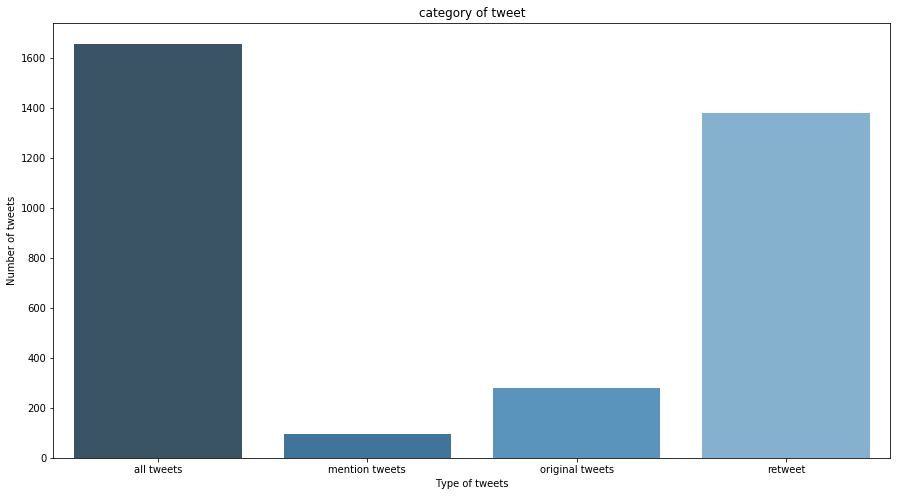

In [15]:
all_the_tweets = [len(df),len(mention_tweets),len(plain_text_tweets),df['is_retweet'].sum()]
item_list = ['all tweets','mention tweets','original tweets','retweet']
plt.figure(figsize = (15,8))
sns.barplot(x = item_list,y = all_the_tweets,saturation=0.80,palette="Blues_d")
plt.title('category of tweet')
plt.xlabel('Type of tweets')
plt.ylabel('Number of tweets')
plt.show()

In [16]:
# checking most used hashtags
#making list of all the hashtags in the tweets
hashtags = []
hashtags_list = list(df['tweet'].apply(lambda x : re.findall(r"#[a-zA-Z]+",x)))
hashtag_dict = {}
for match in hashtags_list:
    for single_match in match:
        if single_match not in hashtag_dict.keys():
            hashtag_dict[single_match] = 1
        else:
            hashtag_dict[single_match] = hashtag_dict[single_match] + 1


In [22]:
hashtag_ordered_list = sorted(hashtag_dict.items(),key = lambda x : x[1],reverse = True)

In [27]:
hashtags_columns = pd.DataFrame(hashtag_ordered_list)
hashtags_columns.columns = ['hashtags','frequency of the hashtags']

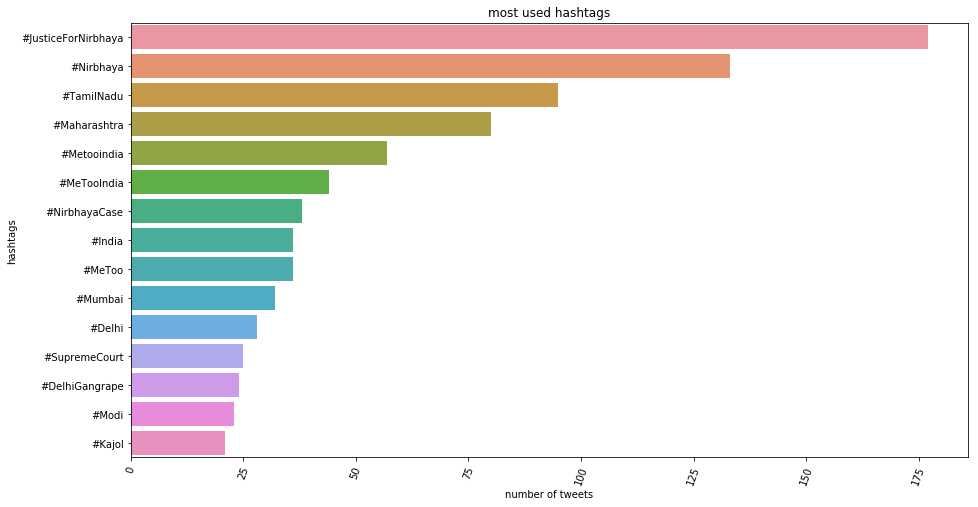

In [75]:
plt.figure(figsize = (15,8))
sns.barplot(data = hashtags_columns[:15],y = 'hashtags',x = 'frequency of the hashtags')
plt.title('most used hashtags')
plt.xlabel('number of tweets')
plt.ylabel('hashtags')
degrees = 70
plt.xticks(rotation=degrees)
plt.show()

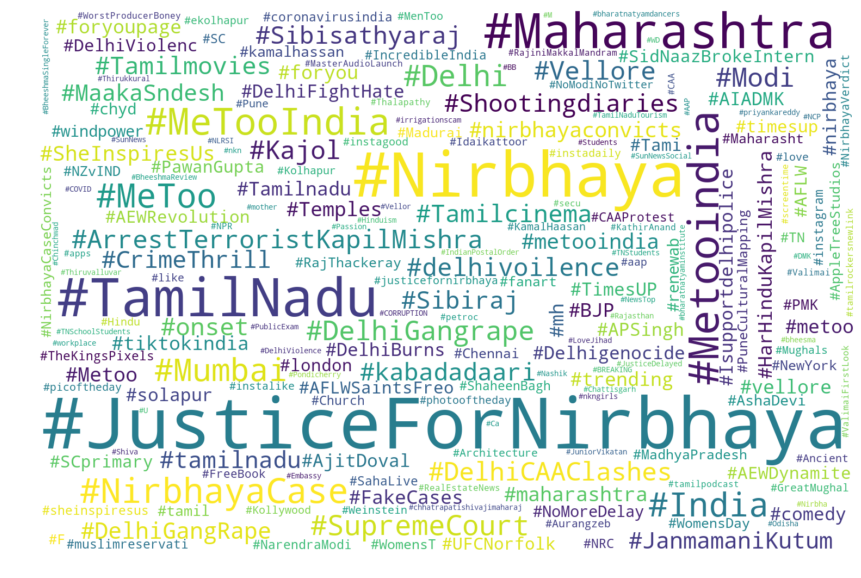

In [85]:
wordcloud = WordCloud(width=1500, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(hashtag_ordered_list))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [65]:
mentions = []
mention_pattern = list(df['tweet'].apply(lambda x : re.findall(r'@[a-zA-Z_]+',x)))
mention_dict = {}
for match in mention_pattern:
    for single_match in match:
        if single_match not in mention_dict.keys():
            mention_dict[single_match] = 1
        else:
            mention_dict[single_match] = mention_dict[single_match] + 1
        

In [70]:
mention_ordered_list = sorted(mention_dict.items(),key = lambda x : x[1],reverse = True)

In [76]:
mention_dataframe = pd.DataFrame(mention_ordered_list)
mention_dataframe.columns = ['mentions','mention frequency']

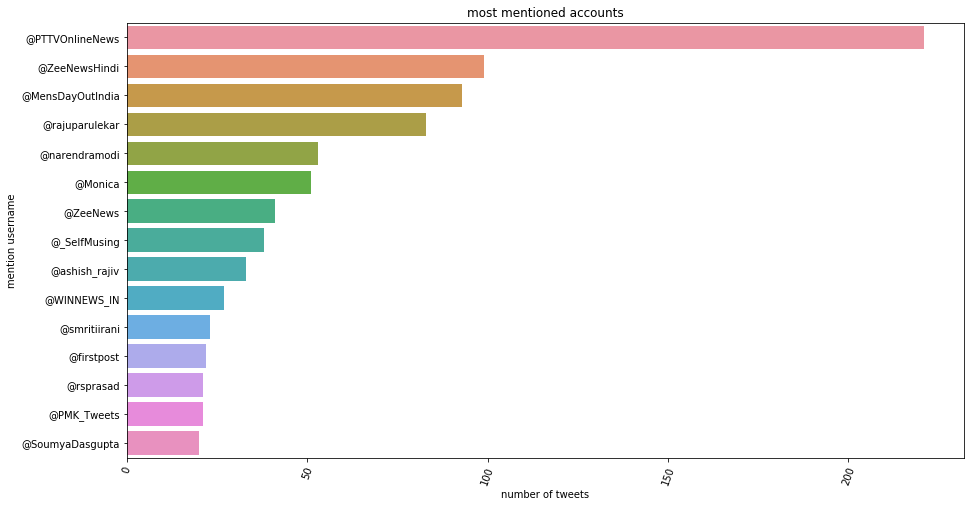

In [80]:
plt.figure(figsize = (15,8))
sns.barplot(data = mention_dataframe[:15],y = 'mentions',x = 'mention frequency')
plt.title('most mentioned accounts')
plt.xlabel('number of tweets')
plt.ylabel('mention username')
degrees = 70
plt.xticks(rotation=degrees)
plt.show()

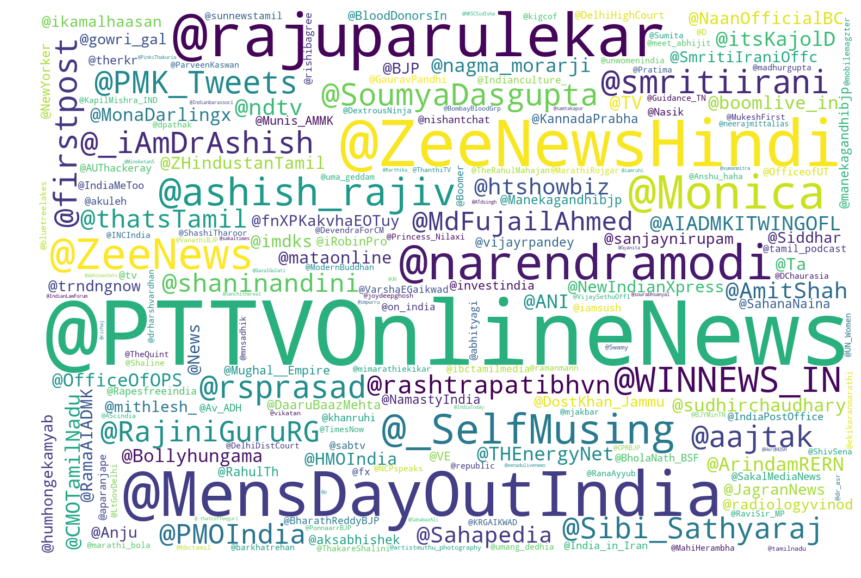

In [84]:
wordcloud = WordCloud(width=1500, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(mention_ordered_list))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [90]:
# looking at users who are posting this tweets
print('number of users tweeting are',len(df['name'].unique()))

number of users tweeting are 1337


In [101]:
# checking the users who have tweeted or retweeted the most
most_active_users = df.groupby('name').count()['tweet'].sort_values(ascending = False)

In [105]:
most_active_users = pd.DataFrame(most_active_users).reset_index()
most_active_users.columns

Index(['index', 'name', 'tweet'], dtype='object')

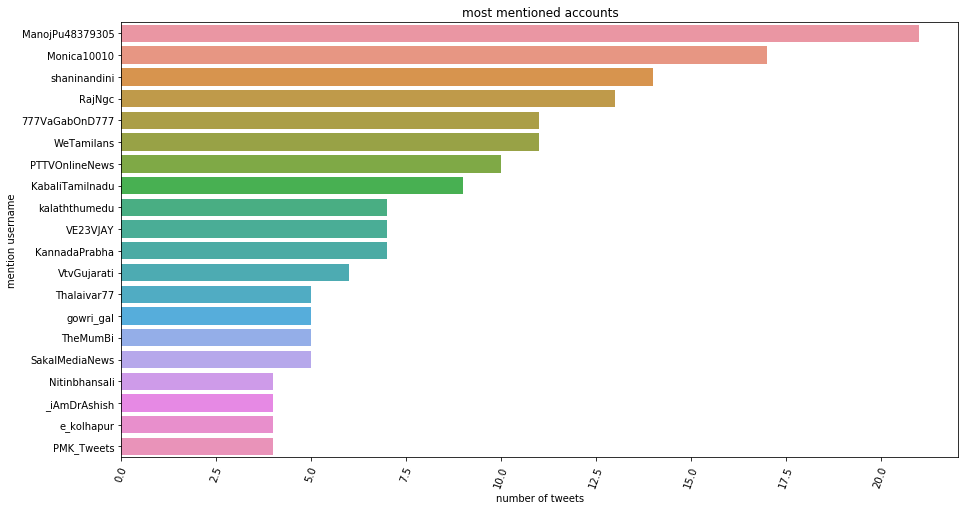

In [106]:
plt.figure(figsize = (15,8))
sns.barplot(data = most_active_users[:20],y = 'name',x = 'tweet')
plt.title('most mentioned accounts')
plt.xlabel('number of tweets')
plt.ylabel('mention username')
degrees = 70
plt.xticks(rotation=degrees)
plt.show()

In [110]:
# time series analysis
df['timestamp'] = pd.to_datetime(df['created'])

In [112]:
def giveday(timestamp):
    day_string = timestamp.day
    return day_string
def givemonth(timestamp):
    month_string = timestamp.month
    return month_string
df['days'] = df['timestamp'].apply(giveday)

In [119]:
days = df.groupby('days').count()['tweet']

In [117]:
def givemonth(timestamp):
    month_string = timestamp.month
    return month_string

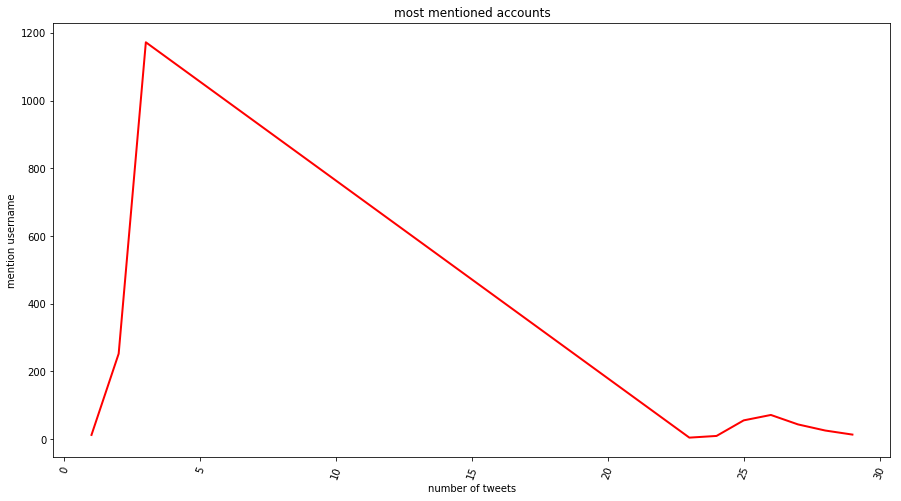

In [126]:
days = pd.DataFrame(days).reset_index()
plt.figure(figsize = (15,8))
sns.lineplot(data = days,x = 'days',y = 'tweet',linewidth = 2,color = 'red')
plt.title('most mentioned accounts')
plt.xlabel('number of tweets')
plt.ylabel('mention username')
degrees = 70
plt.xticks(rotation=degrees)
plt.show()